<span style="font-size:18px; color:red; font-weight:bold">Churn Bancario, construyendo un modelo de Machine Learning en Python</span>

**Enrique Aranaz Tudela**

LInkedin: www.linkedin.com/in/enrique-aranaz-tudela

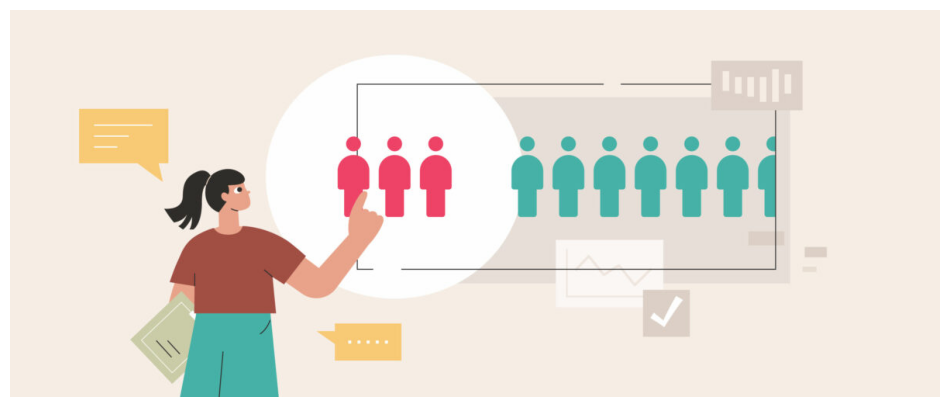

In [26]:
mostrar_imagen('c:/Phyton/Churn.jpeg')

<span style="font-size:24px; color:red; font-weight:bold">Indice</span>

<span style="font-size:18px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

<span style="font-size:18px; color:red; font-weight:bold">1. Definición del problema</span>

    1.1 Introducción al problema que queremos abordar
    1.2 Descripción del dataset y sus variables

<span style="font-size:18px; color:red; font-weight:bold">2. Preparación de los datos</span>

    2.1 Importación de librerias a utilizar
    2.2 Carga del dataset y descripción de los datos
    2.3 Data Cleaning 

        2.3.1 Identificación valores nulos, duplicados, valores no utiles para el modelo o con poca varianza
        2.3.2 Analisis descriptivo univariante y bivariante
        2.3.3 Identificación de valores atípicos y definición de estrategias con ellos
        2.3.4 Data Transforms: Cambiando la escala o distribución de las variables

    2.4 Feature Selection: Identificación de las variables más relevantes

        2.4.1 Filter Methods: Correlación, Chi-cuadrado y Anova
        2.4.2 Filter Methods empleando el metodo K-best
        2.4.3 Embedded Methods: RandomForest

        2.4.4 Conclusiones Feature Selection

    2.5 Reducción de la dimensionalidad de los datos
    2.6 Feature engineering: Creación de nuevas variables

<span style="font-size:18px; color:red; font-weight:bold">3. Entrenamiento y evaluación de modelos</span>

    3.1 Elección de algoritmos de machine learning adecuados para el problema.
    3.2 Aplicación de RamdonOverSampler para corregir problema de desequilibrio. 
    3.3 Entrenamiento de los modelos y evaluación de su rendimiento. 
    3.4 Selección de los dos mejores modelos y optimización (ajuste hiperparámetros).

<span style="font-size:18px; color:red; font-weight:bold">4. Modelo final</span>

    4.1 Rendimiento del modelo
    4.2 Segmentación de nuestra cartera de clientes y descripción de cada segmento en función de las características más relevantes

<span style="font-size:18px; color:red; font-weight:bold">5. Conclusiones y recomendaciones</span>


<span style="font-size:24px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

In [32]:
# Librerias básicas:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pylab
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
from scipy.stats import probplot
from scipy.stats import stats
from scipy.stats import mstats

# Feature Selection, Preprocesado, Modelos, Métricas, GridSearch:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits

import warnings
warnings.filterwarnings("ignore")

In [34]:
# Funciones vamos a utilizar

def plot_vector_charts(vector_cols, titulo):
    # Definir una paleta de colores personalizada
    color_palette = ["#800000", "#8000ff", "#6aac90", "#5833ff", "#da8829"]
    color_pastel = ["#53D021", "#EB2325"]
    bar_palette = {0: 'blue', 1: 'red'}
    colors = ["#53D021", '#EB2325']
    
    # Configurar la figura con constrained_layout
    fig, axes = plt.subplots(len(vector_cols), 2, figsize=(16, 8))  # Aumentar el ancho de la figura
    fig.patch.set_facecolor("#ffe6e6")

    # Título del gráfico
    fig.suptitle(titulo, fontsize=10, fontweight='bold', fontfamily='serif', color="#000000")

    # Crear gráficos de pastel y de barras para cada columna categórica
    for i, col in enumerate(vector_cols):
        # Gráfico de pastel
        pie_ax = axes[i, 0]
        (df[col].value_counts() * 100.0 / len(df)).plot.pie(
            autopct=lambda p: f'{p:.1f}%', fontsize=8, ax=pie_ax, colors=color_palette, textprops={'color': 'black'})
        pie_ax.set_ylabel('')
        pie_ax.set_title(col, fontsize=8, backgroundcolor='skyblue')

        # Agrupar datos por la columna actual y estado de salida
        churn_data = df.groupby([col, 'Exited']).size().unstack()

        # Crear gráfico de barras apiladas
        bar_ax = axes[i, 1]
        ax = churn_data.plot(kind='bar', stacked=True, color=colors, rot=0, ax=bar_ax)
        ax.legend(labels=['Stayed', 'Churned'], fontsize=8)  # Tamaño de la leyenda reducido
        ax.set_title(f'{col} Distribution and Churn rate', fontsize=8)  # Tamaño del título reducido
        ax.set_ylabel('Customer Count')

        # Añadir anotaciones de porcentaje
        for p in ax.patches:
            w, h = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if x == -0.25:
                col_sum = churn_data.T.sum().iloc[0]
            else:
                col_sum = churn_data.T.sum().iloc[1]

            temp = np.array(round(h * 100 / col_sum, 1))  # Redondear a un decimal
            anot = str(temp)
            ax.annotate(anot + '%', (x + 0.15, y + h / 2), color='white', weight='bold', size=8)  # Tamaño de fuente reducido

        # Añadir líneas discontinuas al eje y
        ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

    # Ajustar manualmente el diseño para aumentar el espacio vertical entre gráficos
    plt.subplots_adjust(hspace=0.6, wspace=0.2)  # Reducir el espacio horizontal entre subplots
    plt.show()

def mostrar_imagen(ruta_imagen):
    img = mpimg.imread(ruta_imagen)
    plt.figure(figsize=(12, 10))
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes
    plt.show()

def plot_chart(titulo):

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(8, 4))
    background_color = "#ffe6e6"
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    # Crear el gráfico de barras horizontal
    sns.barplot(x='f1_score', y='Modelo', hue='Modelo', data=Model_com_df, ax=ax, palette='viridis', legend=False)

    # Añadir etiquetas y título
    ax.set_title(titulo, fontsize=10, fontweight='bold')
    ax.set_xlabel('f1_score', fontsize=12)
    ax.set_ylabel('Modelo', fontsize=12)

    # Añadir valores de f1_score a las barras con un decimal
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}', xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords="offset points", fontsize=8, fontweight='bold')

    # Mostrar el gráfico
    plt.show()

<span style="font-size:24px; color:red; font-weight:bold">Epigrafes 1 y 2 en ChurnBanksEDA(Parte1).ipynb</span>

## 3. Entrenamiento y evaluación de modelos

### 3.1 Elección de algoritmos de machine learning adecuados para el problema.

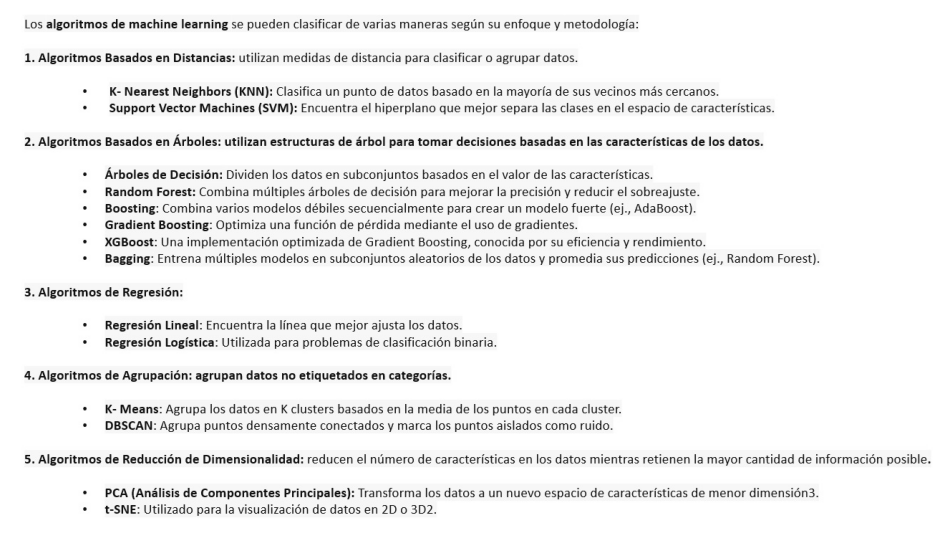

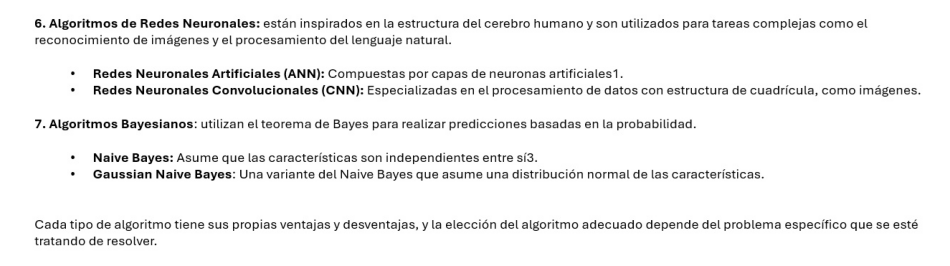

In [109]:
mostrar_imagen('c:/Phyton/AlgoritmosML1.jpg')
mostrar_imagen('c:/Phyton/AlgoritmosML2.jpg')

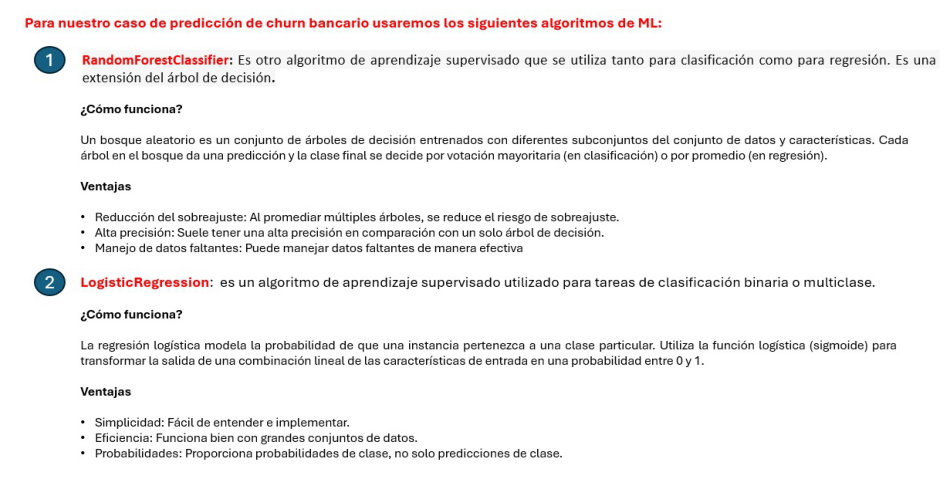

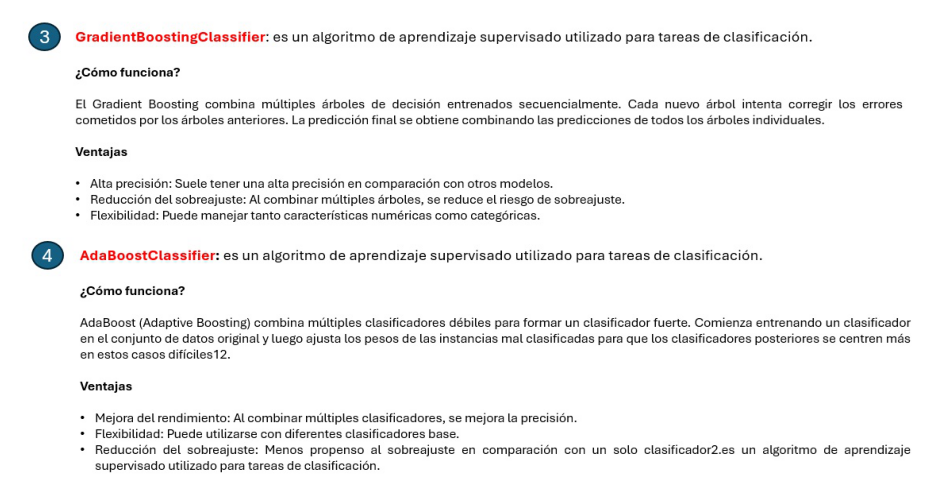

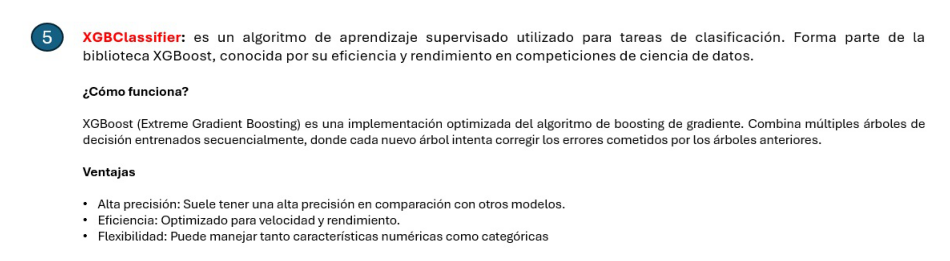

In [111]:
mostrar_imagen('c:/Phyton/ML1.jpg')
mostrar_imagen('c:/Phyton/ML2.jpg')
mostrar_imagen('c:/Phyton/ML3.jpg')

### 3.2 Aplicación de RamdonOverSampler para corregir problema de desequilibrio.

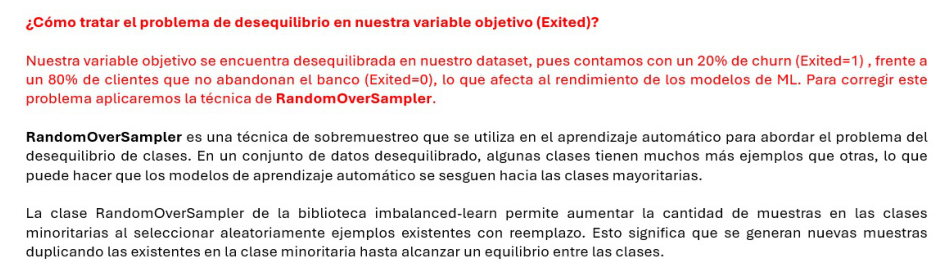

In [113]:
mostrar_imagen('c:/Phyton/RandomOverSampler.jpg')

### 3.3 Entrenamiento de los modelos y evaluación de su rendimiento.

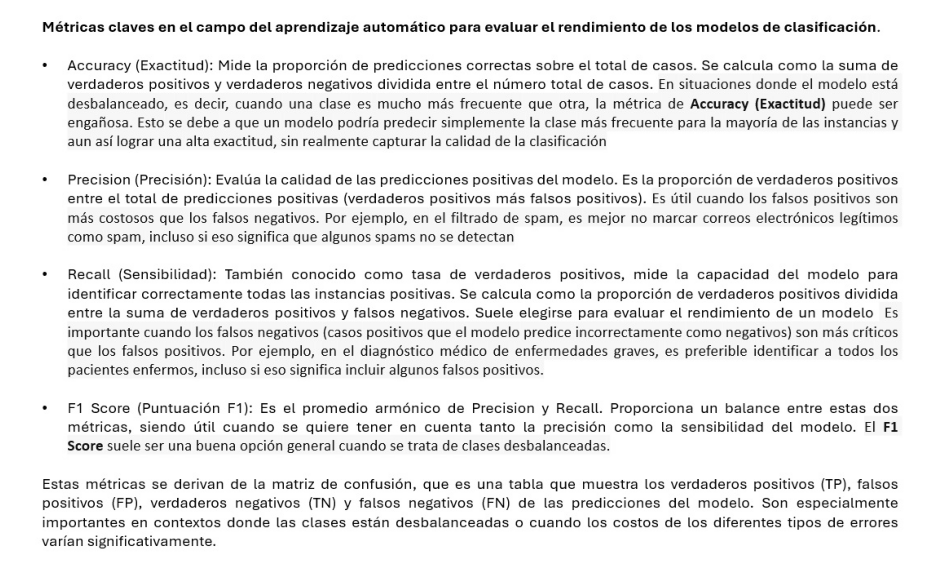

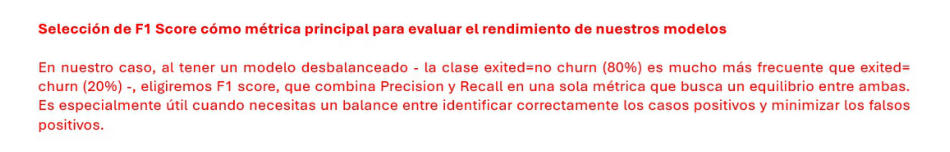

In [115]:
mostrar_imagen('c:/Phyton/Metricas1.jpg')
mostrar_imagen('c:/Phyton/Metricas2.jpg')

In [130]:
# Importamos Dataset ya trabajado con EDA
df=pd.read_csv('c:/Phyton/Customer-Churn-RecordsEDA.csv')
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction_Score,Point_Earned,Geography_Germany,Geography_Spain,Card_Type_GOLD,Card_Type_PLATINUM,Card_Type_SILVER
0,619,0,42,2,0.00,1,1,1,101348.88,1,2,464,False,False,False,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,3,456,False,True,False,False,False
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3,377,False,False,False,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,5,350,False,False,True,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,5,425,False,True,True,False,False


In [121]:
# Seleccionamos las features que vamos a usar en nuestro entrenamiento, descartando las no significativas
selected_features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Point_Earned', 'Geography_Germany','Geography_Spain' ]

In [123]:
# Definimos una función que utilizaremos para ir entrenando el grupo de modelos que hemos elegido

def entrenar_modelos (X):

    df_metricas = pd.DataFrame(columns=['Modelo', 'Sampling','Accuracy', 'Recall','f1_score','Precision'])

    #Definiendo los modelos que vamos a utilizar

    y= df['Exited']
    
    if sampling == "No Sampling":
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    
    else:
        #Aplicación RandomOverSampler para correfgir desequilibrio
        rand_over_samp = RandomOverSampler(random_state=42)
        X_samp1, y_samp1 = rand_over_samp.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_samp1, y_samp1, test_size=0.3, random_state=101)

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    modelos = [RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42),
          LogisticRegression(max_iter=5000),
          GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=50,random_state=42),
          AdaBoostClassifier(learning_rate= 1.0, n_estimators= 5, random_state=42),
          #RandomForestClassifier(max_depth=10, min_samples_split=10),
          #XGBClassifier(max_depth=None, n_estimators=100, random_state=42)
          XGBClassifier(booster='gbtree', max_depth=None, n_estimators=100, random_state=42)
         ]

#Impureza de Gini: Este método se utiliza para decidir la división óptima en un árbol de decisión. Funciona especialmente bien con
#objetivos categóricos y realiza divisiones binarias

    num=0
    for modelo in modelos:
        print("-"*50)
        print(f'Modelo: {type(modelo).__name__}')

        pipe = Pipeline([('modelo', modelo)])
    
        #Train the model
        pipe.fit(X_train, y_train)

        # Obtendo as previsões para novos dados, usando os dados de teste
        y_pred = pipe.predict(X_test)

        # Calculando a matrix de confusão
        cm=confusion_matrix(y_test, y_pred)
        print(cm)
    
        #print(classification_report(y_test,y_pred))
        print(classification_report(y_test, y_pred, zero_division=1)) # zero_division=1 se añade para evitar warning

        # Suponiendo que y_test y y_pred ya están definidos
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        recall = round(recall_score(y_test, y_pred), 3)
        f1 = round(f1_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred, zero_division=1), 3)

        print("Accuracy:", accuracy)
        print("Recall:", recall)
        print("f1_score:", f1)
        print("Precision:", precision)

        df_metricas.loc[num] = [type(modelo).__name__, sampling, accuracy, recall,
                            f1,precision]
        num = num +1

    return df_metricas

Variables que vamos a utilizar para predecir el churn

In [125]:
selected_features

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'IsActiveMember',
 'EstimatedSalary',
 'Point_Earned',
 'Geography_Germany',
 'Geography_Spain']

**Metodo 1:** Pruebo con las variables seleccionadas sin aplicar over sampling 

In [ ]:
# Metodo 1
X= df[selected_features]
sampling="No Sampling"
df_metricas = entrenar_modelos (X)

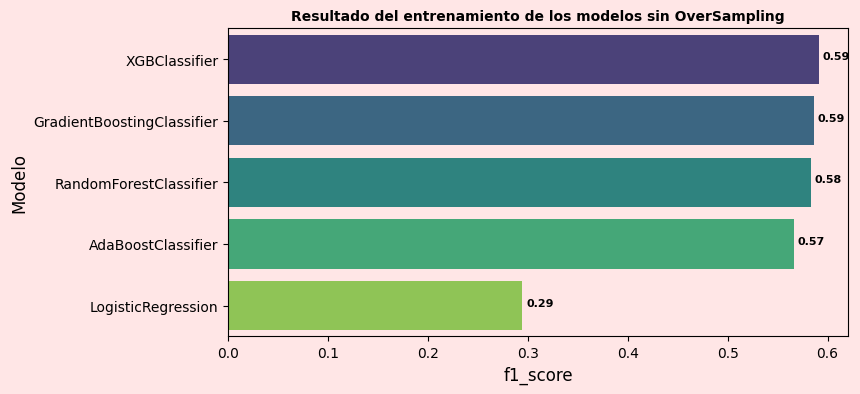

,Modelo,Sampling,Accuracy,Recall,f1_score,Precision
4,XGBClassifier,No Sampling,0.850,0.520,0.591,0.684
2,GradientBoostingClassifier,No Sampling,0.864,0.465,0.586,0.792
0,RandomForestClassifier,No Sampling,0.860,0.470,0.583,0.767
3,AdaBoostClassifier,No Sampling,0.850,0.470,0.566,0.709
1,LogisticRegression,No Sampling,0.806,0.194,0.294,0.605


In [132]:
Model_com=pd.DataFrame(df_metricas)
Model_com_df=Model_com.sort_values(by='f1_score',ascending=False)
plot_chart ("Resultado del entrenamiento de los modelos sin OverSampling")
print("")
Model1_com_df=Model_com_df.copy()
Model_com_df

**Metodo 2:** Repito ahora pero aplicando RamdonOverSampler para balancear y evitar 

In [140]:
# Metodo 2
X= df[selected_features]
sampling="OverSamp."
df_metricas = entrenar_modelos (X)

--------------------------------------------------
Modelo: RandomForestClassifier
[[2182  191]
 [  64 2341]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2373
           1       0.92      0.97      0.95      2405

    accuracy                           0.95      4778
   macro avg       0.95      0.95      0.95      4778
weighted avg       0.95      0.95      0.95      4778

Accuracy: 0.947
Recall: 0.973
f1_score: 0.948
Precision: 0.925
--------------------------------------------------
Modelo: LogisticRegression
[[1653  720]
 [ 696 1709]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      2373
           1       0.70      0.71      0.71      2405

    accuracy                           0.70      4778
   macro avg       0.70      0.70      0.70      4778
weighted avg       0.70      0.70      0.70      4778

Accuracy: 0.704
Recall: 0.711
f1_score: 0.707
Precision: 0.704
------

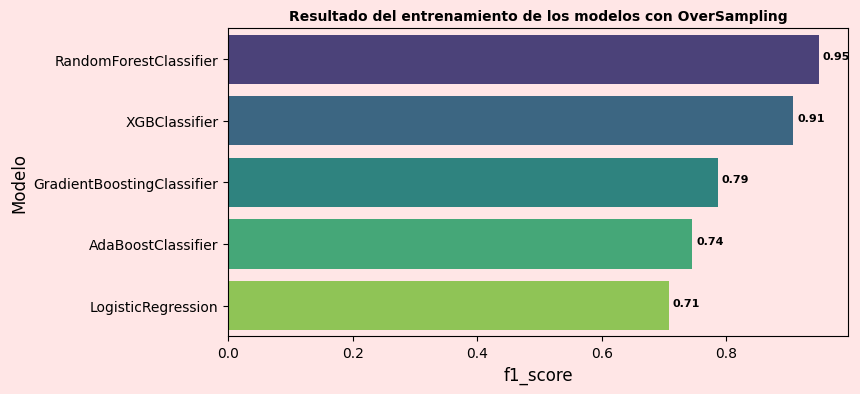

,Modelo,Sampling,Accuracy,Recall,f1_score,Precision
0,RandomForestClassifier,OverSamp.,0.947,0.973,0.948,0.925
4,XGBClassifier,OverSamp.,0.903,0.947,0.907,0.871
2,GradientBoostingClassifier,OverSamp.,0.788,0.775,0.786,0.798
3,AdaBoostClassifier,OverSamp.,0.750,0.726,0.745,0.765
1,LogisticRegression,OverSamp.,0.704,0.711,0.707,0.704


In [142]:
Model_com=pd.DataFrame(df_metricas)
Model_com_df=Model_com.sort_values(by='f1_score',ascending=False)
plot_chart ("Resultado del entrenamiento de los modelos con OverSampling")
print("")
Model2_com_df=Model_com_df.copy()
Model_com_df

Vamos a hacer un mapa de calor que muestre como se han comportado todos los modelos entrenados

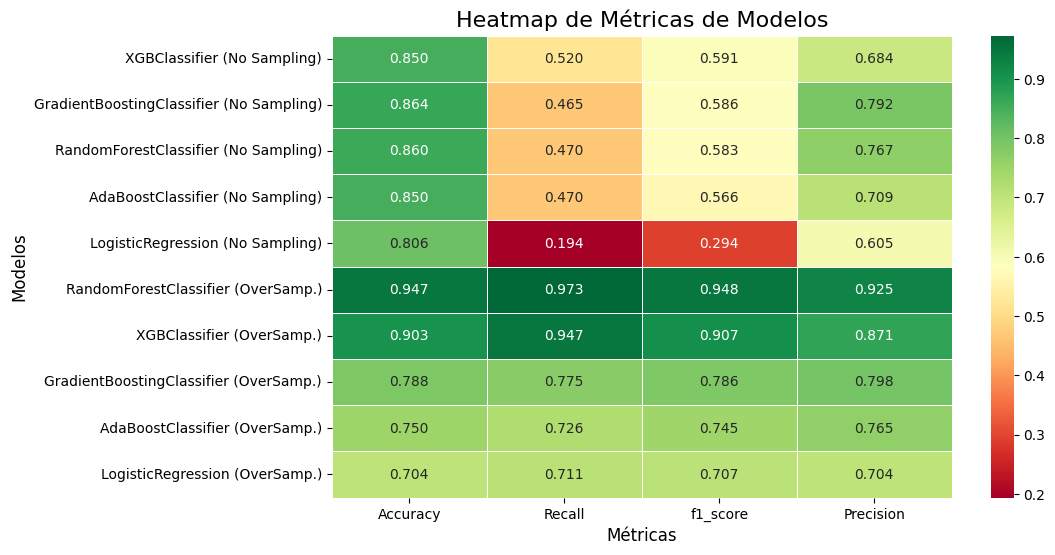

In [144]:
# Unir los DataFrames
combined_df = pd.concat([Model1_com_df, Model2_com_df], ignore_index=True)

# Modificar el nombre del modelo para incluir el tipo de muestreo entre paréntesis
combined_df['Modelo'] = combined_df.apply(lambda row: f"{row['Modelo']} ({row['Sampling']})", axis=1)

# Crear el heatmap sin incluir la columna 'Sampling'
plt.figure(figsize=(10, 6))
heatmap_data = combined_df.set_index('Modelo').drop(columns=['Sampling'])
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', linewidths=.5, fmt='.3f')

# Configurar el título y las etiquetas
plt.title('Heatmap de Métricas de Modelos', fontsize=16)
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Modelos', fontsize=12)
plt.show()

Como podemos ver, los resultados de los modelos muestran una **mejora significativa si aplicamos OverSampling.**

### 3.4 Selección de los dos mejores modelos y optimización (ajuste hiperparámetros).

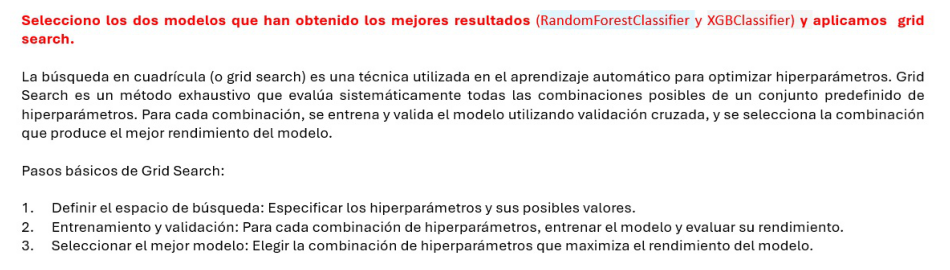

In [147]:
mostrar_imagen('c:/Phyton/Grid.jpg')

In [157]:
from xgboost import XGBClassifier, plot_importance

def evaluationModel(y_true, y_pred):
    # Calcular la matriz de confusión
    cn = confusion_matrix(y_true, y_pred)
    
    # Calcular el porcentaje de cada celda sobre el total de la fila
    cn_percent = cn / cn.sum(axis=1, keepdims=True) * 100
    
    # Nombres personalizados para las celdas
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    # Crear anotaciones combinadas de nombres, números absolutos y porcentajes
    combined_labels = np.array([f'{name}\n{value}\n{percent:.2f}%' for name, value, percent in zip(names, cn.flatten(), cn_percent.flatten())]).reshape(2, 2)
    
    # Crear el heatmap
    sns.heatmap(cn, annot=combined_labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
    
    # Añadir etiquetas y título
    plt.xlabel('Predicted Label')  
    plt.ylabel('True Label')  
    plt.title('Confusion Matrix') 
    plt.show()
    
    # Imprimir el reporte de clasificación
    cr = classification_report(y_true, y_pred)
    print(cr)

def entrenar_modelos_grid (X):
    
    df_metricas = pd.DataFrame(columns=['Modelo', 'Accuracy', 'Recall', 'f1_score', 'Precision'])
    X= df[selected_features]
    y= df['Exited']
    
    if sampling == "No":
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    else:
        rand_over_samp = RandomOverSampler(random_state=42)
        X_samp1, y_samp1 = rand_over_samp.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_samp1, y_samp1, test_size=0.3, random_state=101)

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    modelos = {
        'XGBClassifier': {
            'model': XGBClassifier(objective='binary:logistic', nthread=4, seed=42),
            'params': {
                'max_depth': range(2, 10, 1),
                'n_estimators': range(60, 220, 40),
                'learning_rate': [0.1, 0.01, 0.05]
            }
        },
        'RandomForestClassifier': {
    'model': RandomForestClassifier(random_state=42),
    'params': {
        'n_estimators': [200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']  # Añadido el criterio
    }
}
    }

#n_estimators: Este parámetro define el número de árboles en el bosque. Un mayor número de árboles puede mejorar la precisión del modelo,
#pero también incrementa el tiempo de entrenamiento.
#max_depth: Este parámetro establece la profundidad máxima de cada árbol. None significa que los nodos se expanden hasta que todas las hojas
#son puras o contienen menos muestras que min_samples_split. Las profundidades de 10, 20 y 30 limitan la profundidad de los árboles,
#lo que puede ayudar a prevenir el sobreajuste.
#min_samples_split: Este parámetro indica el número mínimo de muestras requeridas para dividir un nodo interno. Valores más altos pueden 
#llevar a árboles más generales.
#min_samples_leaf: Este parámetro define el número mínimo de muestras que debe tener una hoja. Valores más altos pueden suavizar el modelo.
#Estos hiperparámetros te permiten ajustar el modelo para encontrar el equilibrio adecuado entre sesgo y varianza, mejorando así su
#rendimiento en datos no vistos.
#learning_rate: Este parámetro controla la tasa de aprendizaje del modelo. Valores más bajos hacen que el modelo aprenda más lentamente,
#lo que puede resultar en un mejor rendimiento general, pero requiere más iteraciones
    
    num = 0
    for model_name, model_info in modelos.items():
        print("-" * 50)
        print(f'Modelo: {model_name}')

        grid_search = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], scoring='f1', refit=True, n_jobs=-1, cv=5, verbose=1)
        grid_search.fit(scaled_X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(scaled_X_test)

        #cm = confusion_matrix(y_test, y_pred)
        #print(cm)
        #print(classification_report(y_test, y_pred))
        evaluationModel(y_test, y_pred)

        accuracy = round(accuracy_score(y_test, y_pred), 3)
        recall = round(recall_score(y_test, y_pred), 3)
        f1 = round(f1_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred), 3)

        print("Accuracy:", accuracy)
        print("Recall:", recall)
        print("f1_score:", f1)
        print("Precision:", precision)
        print("Best Params:", grid_search.best_params_)

        df_metricas.loc[num] = [model_name, accuracy, recall, f1, precision]

        # Predecir probabilidades sobre el conjunto de prueba
        y_prob = best_model.predict_proba(scaled_X_test)[:, 1]  # Probabilidad de la clase 1

        # Calcular la curva ROC y el AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)

        # Graficar la curva ROC
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Si el modelo es RandomForestClassifier, graficar la importancia de las características
        if model_name == 'RandomForestClassifier':
            importances = best_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            plt.figure(figsize=(10, 6))
            plt.title("Feature Importances")
            plt.bar(range(X.shape[1]), importances[indices], align="center")
            plt.xticks(range(X.shape[1]), [selected_features[i] for i in indices], rotation=90)
            plt.xlim([-1, X.shape[1]])
            plt.show()
        
        num = num +1

    return df_metricas

--------------------------------------------------
Modelo: XGBClassifier
Fitting 5 folds for each of 96 candidates, totalling 480 fits


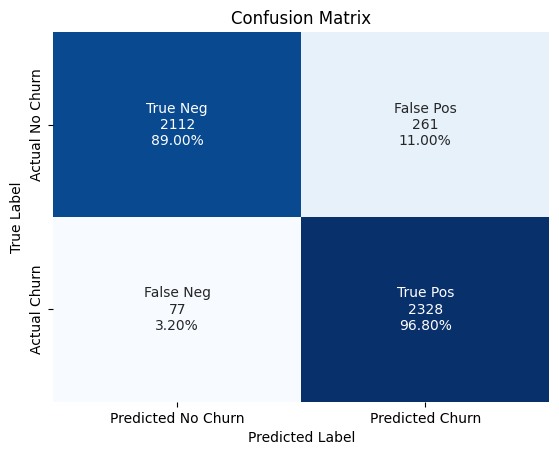

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      2373
           1       0.90      0.97      0.93      2405

    accuracy                           0.93      4778
   macro avg       0.93      0.93      0.93      4778
weighted avg       0.93      0.93      0.93      4778

Accuracy: 0.929
Recall: 0.968
f1_score: 0.932
Precision: 0.899
Best Params: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}


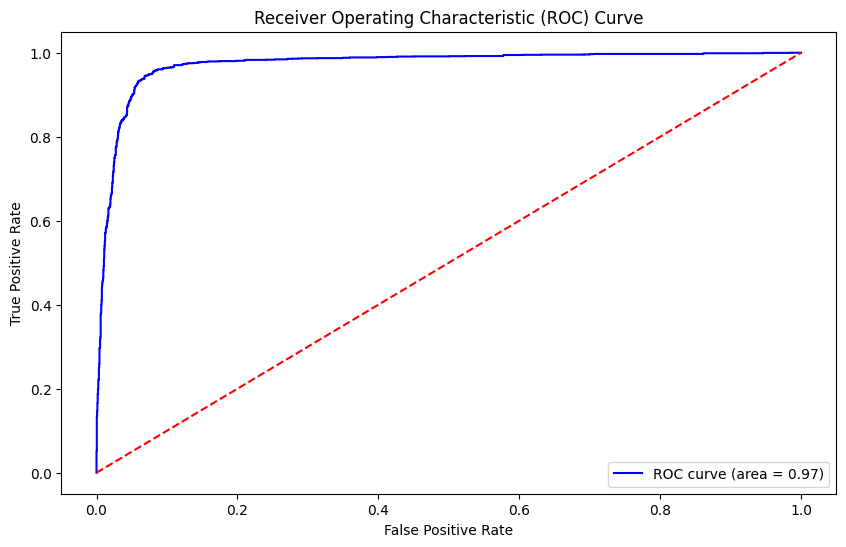

--------------------------------------------------
Modelo: RandomForestClassifier
Fitting 5 folds for each of 108 candidates, totalling 540 fits


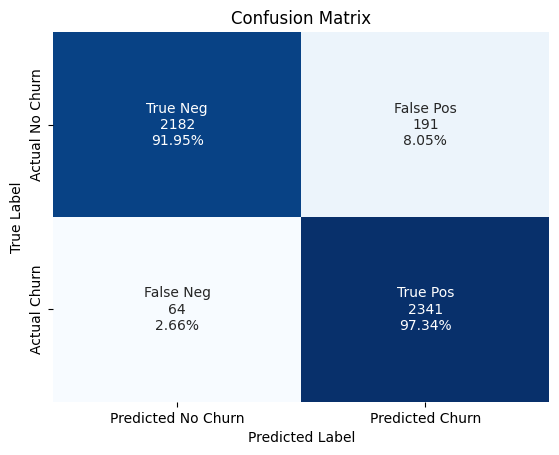

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2373
           1       0.92      0.97      0.95      2405

    accuracy                           0.95      4778
   macro avg       0.95      0.95      0.95      4778
weighted avg       0.95      0.95      0.95      4778

Accuracy: 0.947
Recall: 0.973
f1_score: 0.948
Precision: 0.925
Best Params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


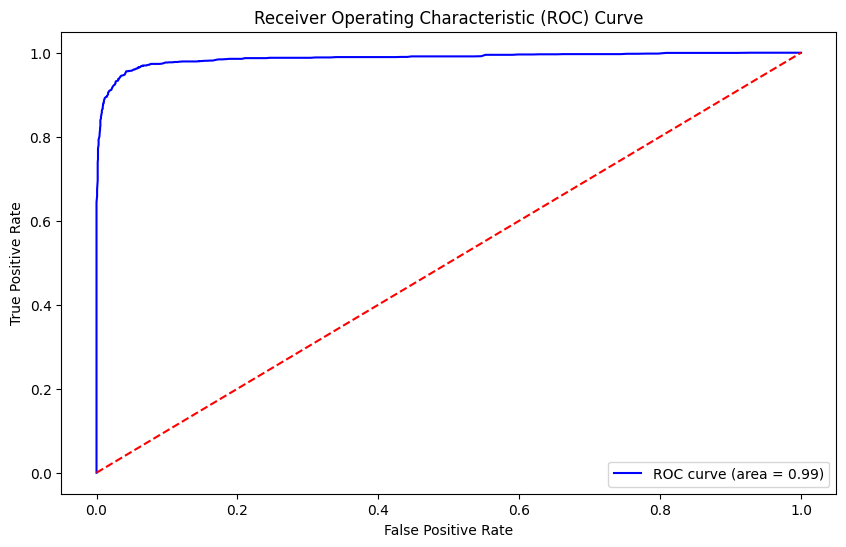

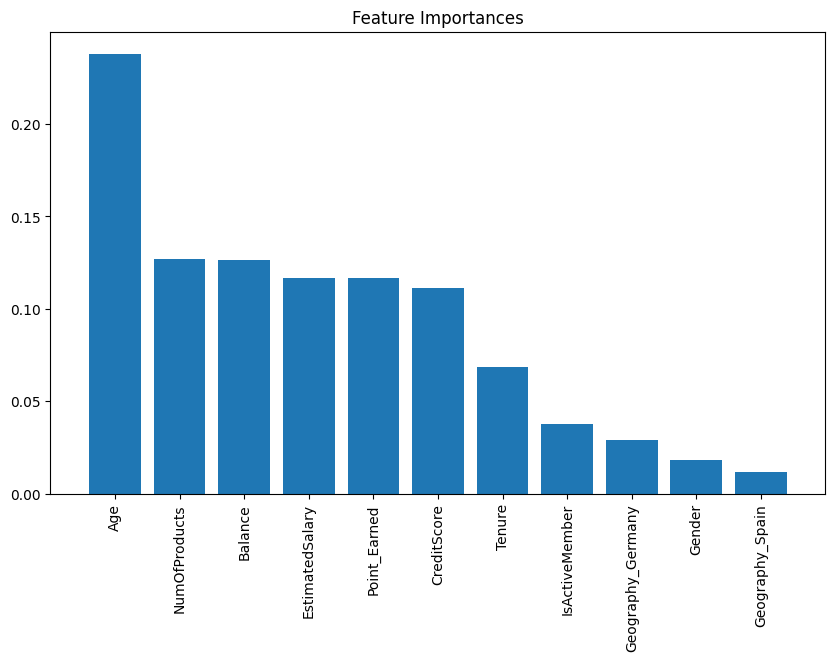

In [159]:
# Ajuste mejores modelos con Grid y aplico RamdonOverSampler
sampling="RandomOverSampler"
df_metricas = entrenar_modelos_grid (X)

## 4. Modelo final

Elegimos cómo **mejor modelo el RandomForestClassifier,** pues tiene un muy buen rendimiento y ligeramente superior al 
XGBClassifier (0.949 de f1_score frente al 0.932 de este).

In [161]:
df_metricas.sort_values(by='f1_score',ascending=False)

,Modelo,Accuracy,Recall,f1_score,Precision
1,RandomForestClassifier,0.947,0.973,0.948,0.925
0,XGBClassifier,0.929,0.968,0.932,0.899


### 4.1 Rendimiento del modelo

Matriz de Confusión (Conteos):
Predicted     0     1  Total
Actual                      
0          7771   191   7962
1            36  2002   2038
Total      7807  2193  10000

Matriz de Confusión (Porcentajes):
Predicted          0          1
Actual                         
0          97.601105   2.398895
1           1.766438  98.233562


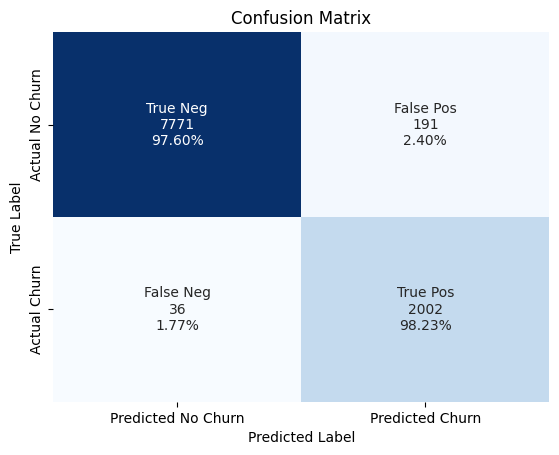

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7962
           1       0.91      0.98      0.95      2038

    accuracy                           0.98     10000
   macro avg       0.95      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [162]:
X= df[selected_features]
y= df['Exited']

rand_over_samp = RandomOverSampler(random_state=42)
X_samp1, y_samp1 = rand_over_samp.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_samp1, y_samp1, test_size=0.3, random_state=101)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.transform(X)  # Escalar todo el DataFrame

modelo = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42)
modelo.fit(scaled_X_train, y_train)

# Predecir probabilidades sobre todo el DataFrame
y_prob = modelo.predict_proba(scaled_X)[:, 1]  # Probabilidad de la clase 1

# Añadir las probabilidades al DataFrame original
df['Probabilidad_Exit'] = y_prob
df['Exited_pred'] = df['Probabilidad_Exit'].apply(lambda x: 1 if x > 0.5 else 0)

# Crear la matriz de confusión con conteos
matriz_confusion = pd.crosstab(df['Exited'], df['Exited_pred'], rownames=['Actual'], colnames=['Predicted'], margins=True, margins_name='Total')

# Calcular los porcentajes sin totales
matriz_confusion_pct = pd.crosstab(df['Exited'], df['Exited_pred'], rownames=['Actual'], colnames=['Predicted'], normalize='index') * 100

print("Matriz de Confusión (Conteos):")
print(matriz_confusion)
print("\nMatriz de Confusión (Porcentajes):")
print(matriz_confusion_pct)

evaluationModel(df['Exited'], df['Exited_pred'])


Vemos que el modelo elegido, **RandomForestClassifier** (max_depth=None, min_samples_split=2, n_estimators=300, random_state=42),
tiene un **muy buen rendimiento**, pues es capaz de **predecir de forma correcta el 98,52% de los clientes que abandonan el banco** (de
los 2038 de los clientes que abandonan es capaz de predecir correctamente 2008 de ellos.)

In [167]:
df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction_Score,Point_Earned,Geography_Germany,Geography_Spain,Card_Type_GOLD,Card_Type_PLATINUM,Card_Type_SILVER,Probabilidad_Exit,Exited_pred
0,619,0,42,2,0.00,1,1,1,101348.88,1,2,464,False,False,False,False,False,0.993333,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,3,456,False,True,False,False,False,0.136667,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3,377,False,False,False,False,False,1.000000,1
3,699,0,39,1,0.00,2,0,0,93826.63,0,5,350,False,False,True,False,False,0.043333,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,5,425,False,True,True,False,False,0.096667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1,300,False,False,False,False,False,0.053333,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,5,771,False,False,False,True,False,0.066667,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,3,564,False,False,False,False,True,0.900000,1
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,2,339,True,False,True,False,False,0.900000,1


In [ ]:
### 4.2 Segmentación de nuestra cartera de clientes y descripción de cada segmento en función de las características más relevantes

A continuación vamos a segmentar nuestra cartera de clientes en función de la probabilidad de abandono, para lo que
entrenaremos un RandomForestClassifier pero con los hiperparametros min_samples_split=2000 y min_samples_leaf=30 ajustados
Con el fin de obtener un numero reducido de segmentos con distinto comportamiento frente al churn.

Las 5 características más importantes son: ['Age', 'NumOfProducts', 'Geography_Germany', 'IsActiveMember', 'Balance']


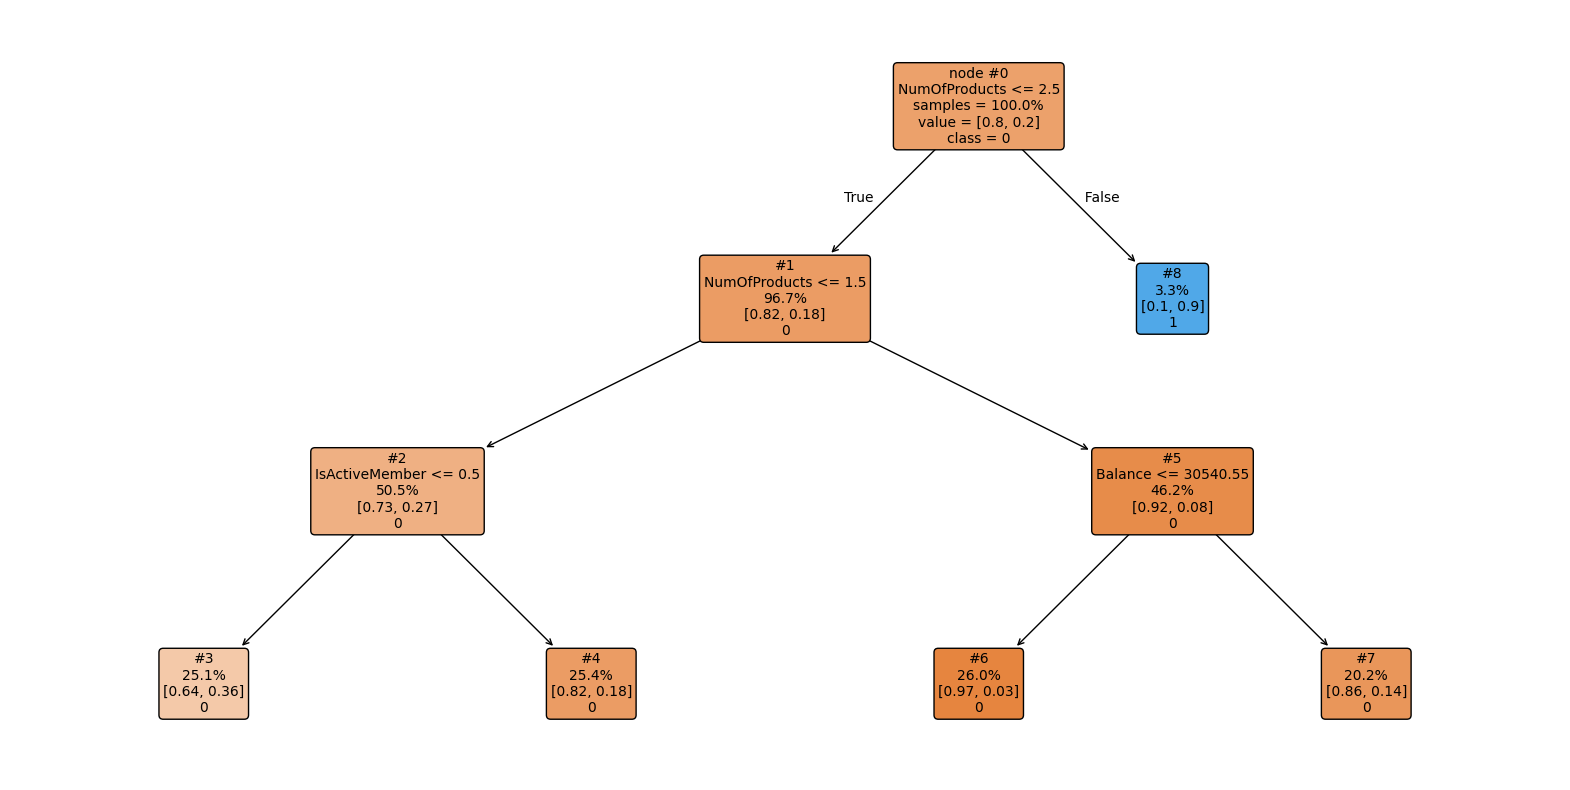

In [172]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Selecciona las características principales y la columna de probabilidades
X= df[selected_features]
y= df['Exited']

rand_over_samp = RandomOverSampler(random_state=42)
X_samp1, y_samp1 = rand_over_samp.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_samp1, y_samp1, test_size=0.3, random_state=101)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.transform(X)  # Escalar todo el DataFrame

forest = RandomForestClassifier(max_depth=None, min_samples_split=2000, n_estimators=300, min_samples_leaf=30, random_state=42)
forest.fit(X, y)

#Obtener las importancias de las características
importances = forest.feature_importances_
features = selected_features

# Crear un DataFrame para ordenar las características por importancia
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

#Seleccionar las 5 características más importantes
top_5_features = importances_df['Feature'].head(5).tolist()
print("Las 5 características más importantes son:", top_5_features)

# Selecciona uno de los árboles del bosque aleatorio
arbol_individual = forest.estimators_[0]

# Visualiza el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(arbol_individual, feature_names=features, filled=True, rounded=True, fontsize=10, 
          proportion=True, impurity=False, class_names=['0', '1'], 
          node_ids=True, label='root', precision=2)

plt.show()

# Obtener las probabilidades de la clase exited=1 para un arbol individual
#probabilidades = forest.predict_proba(X)[:, 1]
probabilidades = arbol_individual.predict_proba(X)[:, 1]

# Añadir las probabilidades al DataFrame original
df['prob_exited_1_reducido'] = probabilidades

# Obtener los índices de los nodos hoja
nodos_hoja = arbol_individual.apply(X)

# Asignar los índices de los nodos hoja a la nueva columna 'nodo' en 'df'
df['Leaf_Node'] = nodos_hoja

El número de segmentos obtenidos es: 5


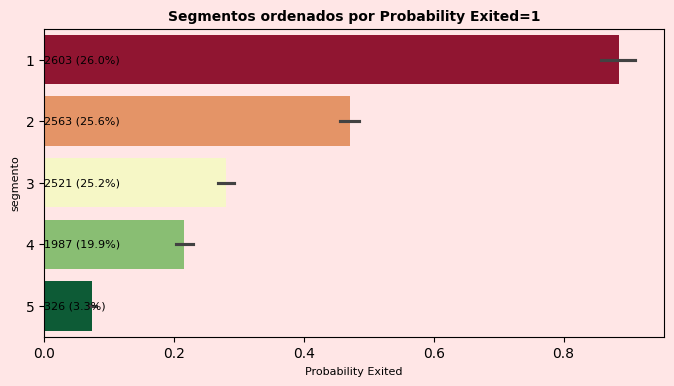


---------------------------------------
Descripción de los segmentos en función de las caracteristicas más relevantes:

          Clientes  %casos  Prob.churn  Edad media  media productos  %clie.Alemania  %clie.IsActiveMember  media balance
segmento                                                                                                                
1              326     3.3        89.7        43.6              3.2            37.0                  44.0        78821.8
2             2521    25.2        36.2        39.1              1.0            29.0                   0.0        98195.9
3             2563    25.6        17.7        40.2              1.0            25.0                 100.0        98902.0
4             1987    19.9        14.1        38.1              2.0            52.0                  53.0       119818.7
5             2603    26.0         2.9        37.4              2.0             0.0                  53.0           17.5



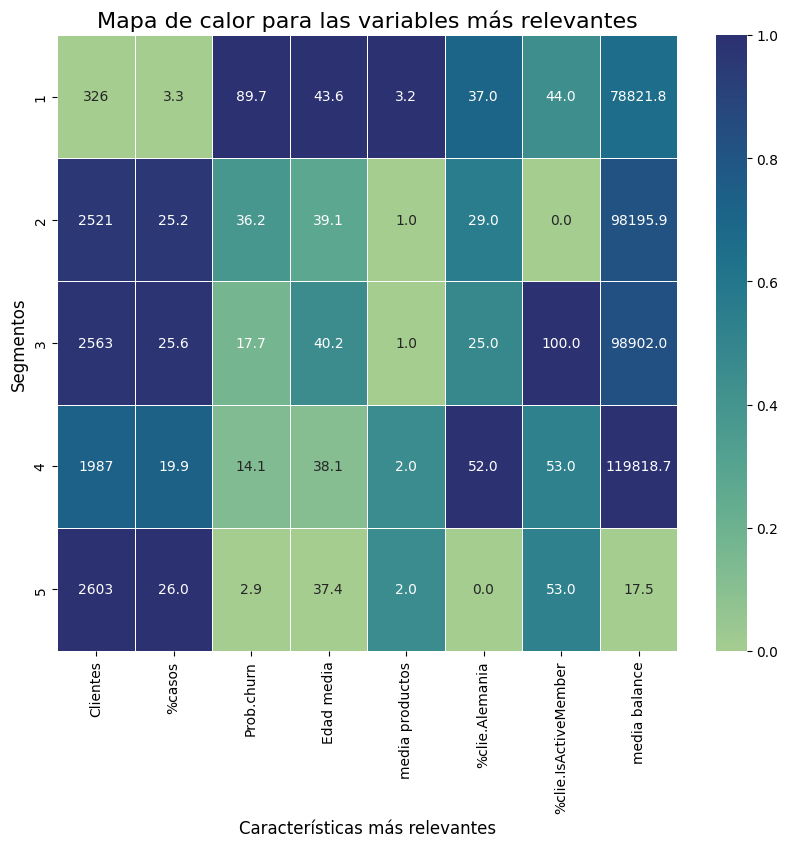

In [174]:
# Contar el número de valores distintos en 'prob_exited_1_reducido'
num_valores_distintos = df['prob_exited_1_reducido'].nunique()

# Imprimir el resultado
print(f"El número de segmentos obtenidos es: {num_valores_distintos}")

# Obtener los valores únicos y ordenarlos de mayor a menor
valores_unicos_ordenados = sorted(df['prob_exited_1_reducido'].unique(), reverse=True)

# Crear un diccionario para mapear los valores únicos a los segmentos
mapeo_segmentos = {valor: i+1 for i, valor in enumerate(valores_unicos_ordenados)}

# Asignar los segmentos al DataFrame usando el mapeo
df['segmento'] = df['prob_exited_1_reducido'].map(mapeo_segmentos)

# Calcular el número de casos para cada segmento
num_casos_por_segmento = df.groupby('segmento').size()

# Calcular la media de la probabilidad de salida multiplicada por 100 para cada segmento
media_probabilidad_exit_por_segmento = df.groupby('segmento')['prob_exited_1_reducido'].mean() * 100
media_edad = df.groupby('segmento')['Age'].mean().round(1)
media_num_prod = df.groupby('segmento')['NumOfProducts'].mean().round(1)
media_balance = df.groupby('segmento')['Balance'].mean().round(1)

# Calcular el número total de casos
total_cases = df.shape[0]

# Calcular el número de casos donde Geography_Germany=1 para cada segmento
casos_alemania_por_segmento = df[df['Geography_Germany'] == 1].groupby('segmento').size()

#Calcular el porcentaje de casos de Alemania sobre el total de casos en cada segmento
porcentaje_casos_alemania = (casos_alemania_por_segmento / num_casos_por_segmento) * 100

# Calcular el número de casos donde IsActiveMember=1 para cada segmento
casos_IsActiveMember_segmento = df[df['IsActiveMember'] == 1].groupby('segmento').size()

#Calcular el porcentaje de casos de IsActiveMember=1 sobre el total de casos en cada segmento
porcentaje_casos_IsActiveMember = (casos_IsActiveMember_segmento / num_casos_por_segmento) * 100

# Reemplaza los valores NaN por 0
porcentaje_casos_alemania.fillna(0, inplace=True)
porcentaje_casos_IsActiveMember.fillna(0, inplace=True)

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    'Clientes': num_casos_por_segmento,
    '%casos': (num_casos_por_segmento/ total_cases) * 100,
    'Prob.churn': media_probabilidad_exit_por_segmento,
    'Edad media': media_edad,
    'media productos': media_num_prod,
    '%clie.Alemania': porcentaje_casos_alemania,
    '%clie.IsActiveMember': porcentaje_casos_IsActiveMember,
    'media balance': media_balance,
})

# Redondear los valores a un decimal
resultados_df['Prob.churn'] = resultados_df['Prob.churn'].round(1)
resultados_df['%casos'] = resultados_df['%casos'].round(1)
resultados_df['%clie.Alemania'] = resultados_df['%clie.Alemania'].round(0)
resultados_df['%clie.IsActiveMember'] = resultados_df['%clie.IsActiveMember'].round(0)

# Grafico de probabilidad de churn por smapeo_segmentos

#Asegurarse de que 'segmento' es categórico
df['segmento'] = df['segmento'].astype(str)

# Ordenar el DataFrame por 'Probability Exited=1'
df = df.sort_values(by='segmento', ascending=True)

# Configurar la figura
fig, ax = plt.subplots(figsize=(8, 4))
background_color = "#ffe6e6"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Crear una paleta de colores de rojo a verde
n = df['segmento'].nunique()
colores = plt.cm.RdYlGn(np.linspace(0, 1, n)).tolist()  # Convertir a lista

# Crear el gráfico de barras horizontal con la nueva paleta de colores
sns.barplot(x='Probabilidad_Exit', y='segmento', hue='segmento', data=df, ax=ax, palette=colores, dodge=False, legend=False)


# Añadir etiquetas y título
ax.set_title('Segmentos ordenados por Probability Exited=1', fontsize=10, fontweight='bold')
ax.set_xlabel('Probability Exited', fontsize=8)
ax.set_ylabel('segmento', fontsize=8)

df_totals = df['segmento'].value_counts().reset_index()
df_totals.columns = ['segmento', 'total']
df_totals['percentage'] = (df_totals['total'] / df_totals['total'].sum()) * 100

# Añadir el total de registros y el porcentaje sobre el total en las etiquetas
for i in range(len(df_totals)):
  
    ax.text(0, i, f"{df_totals['total'].iloc[i]} ({df_totals['percentage'].iloc[i]:.1f}%)", 
            color='black', ha="left", va="center", fontsize=8)

# Mostrar el gráfico
plt.show()

# Mostrar los resultados
print()
print('---------------------------------------')
print(f"Descripción de los segmentos en función de las caracteristicas más relevantes:")
print()
print(resultados_df.to_string())
print()

# Creamos un mapa de calor

# Normalizar los datos para la coloración
scaler = MinMaxScaler()
resultados_normalizados = pd.DataFrame(scaler.fit_transform(resultados_df), index=resultados_df.index, columns=resultados_df.columns)

# Crear anotaciones con los valores originales
annot = resultados_df.round(2).astype(str)

# Crear el heatmap con los datos normalizados y anotaciones originales
plt.figure(figsize=(10, 8))
sns.heatmap(resultados_normalizados, annot=annot, fmt='', cmap='crest', linewidths=.5)

# Configurar el título y las etiquetas
plt.title('Mapa de calor para las variables más relevantes', fontsize=16)
plt.xlabel('Características más relevantes', fontsize=12)
plt.ylabel('Segmentos', fontsize=12)
plt.show()

Vemos que obtenemos 5 segmentos con probabilidades significativamente distintas. Si queremos obtener más segmentos
tan sólo tenemos que ejecutar el modelo RandomForestClassifier ajustando el valor de los hiperparametros min_samples_split=2000
y min_samples_leaf=30.

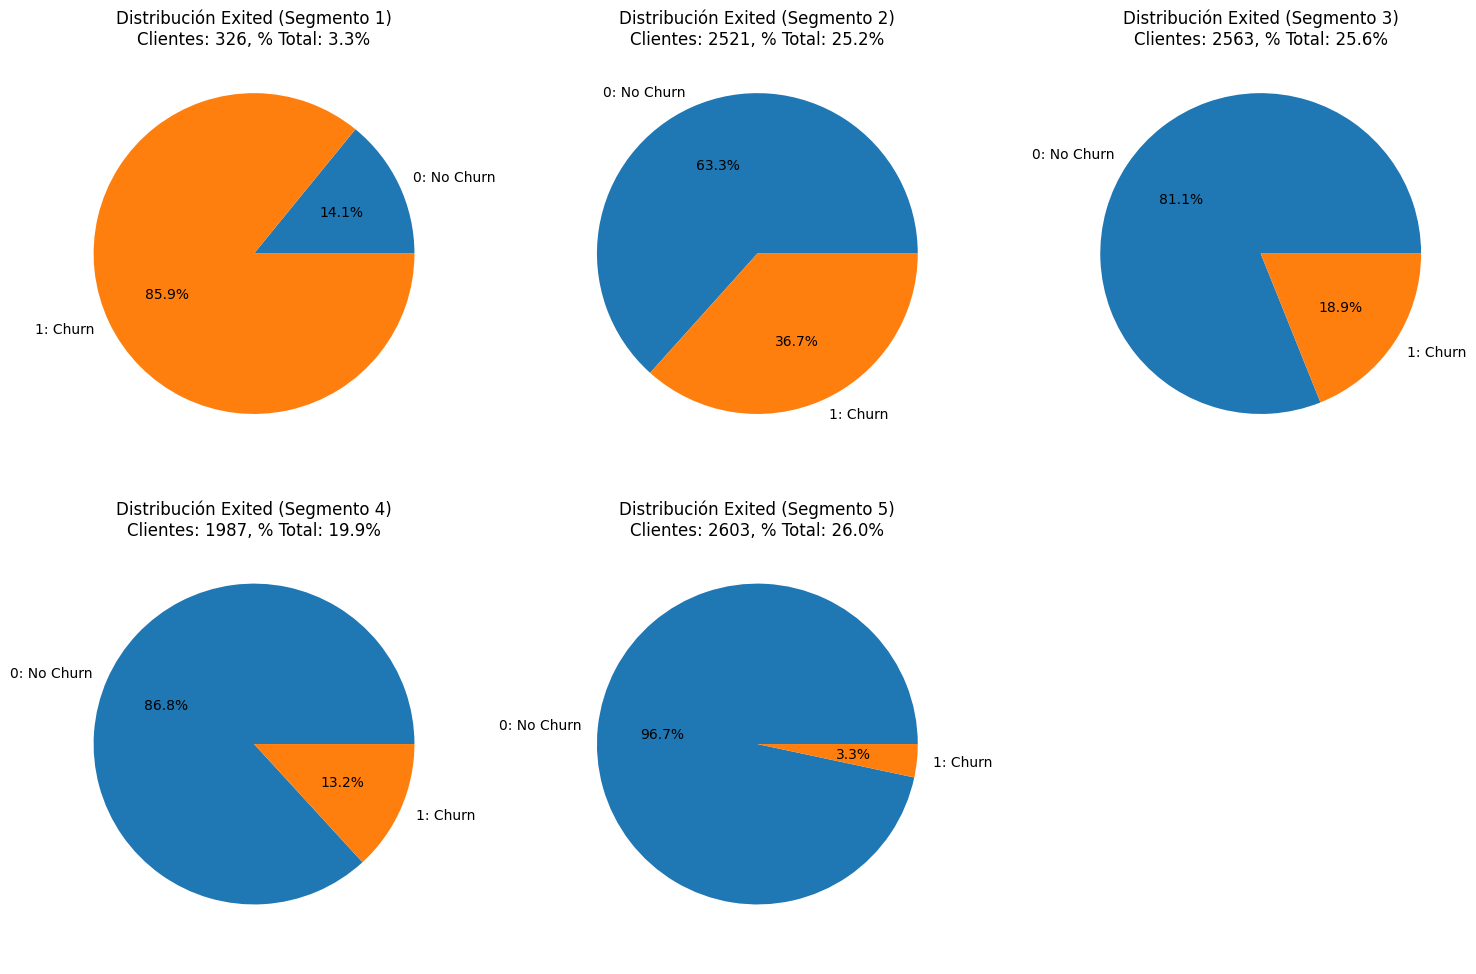

In [176]:
# Obtener los valores únicos de 'segmento'
valores_segmento = sorted(df['segmento'].unique())

# Determinar el número de filas necesarias para tres columnas
num_filas = len(valores_segmento) // 3 + (len(valores_segmento) % 3 > 0)

# Crear una figura con subplots en tres columnas
fig, axs = plt.subplots(num_filas, 3, figsize=(15, num_filas*5))

# Aplanar el array de ejes para facilitar el acceso
axs = axs.flatten()

# Inicializar un contador para los subplots
contador_subplot = 0

# Obtener el número total de casos
total_cases = df.shape[0]

for segmento in valores_segmento:
    # Filtrar el DataFrame por el segmento actual
    subset_df = df[df['segmento'] == segmento]
    
    # Contar los valores de 'Exited' para el segmento actual
    counts = subset_df['Exited'].value_counts()
    
    # Crear las etiquetas para el gráfico
    labels = ['0: No Churn', '1: Churn']
    
    # Asegurarse de que ambas categorías estén presentes
    sizes = [counts.get(0, 0), counts.get(1, 0)]
    
    # Calcular el porcentaje de casos para el segmento actual
    porcentaje_casos = (subset_df.shape[0] / total_cases) * 100
    
    # Crear el gráfico de pastel en el subplot correspondiente
    axs[contador_subplot].pie(sizes, labels=labels, autopct='%.1f%%')
    axs[contador_subplot].set_title(f'Distribución Exited (Segmento {segmento})\nClientes: {subset_df.shape[0]}, % Total: {porcentaje_casos:.1f}%')
    
    # Incrementar el contador de subplots
    contador_subplot += 1

# Ocultar los ejes vacíos si los hay
for i in range(contador_subplot, len(axs)):
    axs[i].axis('off')

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()
